# Modeling Pit Stop Strategy in Formula 1 
Computer Science Capstone Project <br>
Kurtis Wiles 

## Data Pre-processing
In this section, I will take the raw Formula 1 race data and extract the useful information from it so that it can be used to train a neural network on making pit stop decisions. 

### Initial filtering/sampling
This includes removing all strategies with the following conditions:
- Data older than 2014
- Driver didn't complete the race
- Finished outside the top 10
- Finished worse than their starting grid position
- Had a lap exceeding 2:12 minutes
- Pit stops longer than 32 seconds
- Pit stops before lap 5
- Pit stops after lap 65

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

I will start by loading the data and removing columns from the dataframes that will not be needed.

In [6]:
races = pd.read_csv('./data/races.csv')
lap_times = pd.read_csv('./data/lap_times.csv')
pit_stops = pd.read_csv('./data/pit_stops.csv')
results = pd.read_csv('./data/results.csv')

# Remove unneeded columns from races
races = races.iloc[:, 0:6]
races.drop(['round', 'date'], axis=1, inplace=True)

# Remove unneeded columns from results
results = results.loc[:, ['raceId', 'driverId', 'grid', 'positionOrder', 'statusId']]

# Remove unneeded columns from lap_times
lap_times.drop('time', axis=1, inplace=True)

# Remove unneeded columns from pit_stops
pit_stops.drop(['time', 'duration'], axis=1, inplace=True)

The data ultimately fed into the neural network will consist of lap-by-lap data from various drivers across an entire race. If there is bad data from any lap for any reason, it will invalidate the data for that driver’s entire race. This is because I don't want the network to learn from races with unusual or unpredictable circumstances. To easily keep track of this and to easily remove an entire driver's race from the dataframe, I will maintain a separate dataframe for tracking (race, driver) pairs, which I will refer to as strategies.

I will begin to construct this dataframe as well as remove rows from it that contain data I do not want to train on. Data I do not want here consists of:
- Races pre-2014 (this will keep the data relevant to the hybrid era of Formula 1)
- Strategies that did not complete the race (for obvious reasons)
- Strategies that did not result in a top 10 finish (to train only on strategies from successful teams)

In [8]:
# Remove races older than 2014 with Boolean indexing
races = races[races['year'] >= 2014]

# Inner join results with races to create a dataframe of strategies
strategies = results.set_index('raceId').join(races.set_index('raceId'), rsuffix='_race', how='inner')

# Keep only strategies that complete a race
strategies = strategies[strategies['statusId'] == 1]

# Keep only strategies that place top 10
strategies = strategies[strategies['positionOrder'] <= 10]

A column called 'bad' will be added to the strategies dataframe to mark the strategies I want to remove. This will allow me to easily filter them out using boolean indexing after looping through various dataframes and marking the 'bad' ones.

Next, I loop through the strategies to remove those that performed poorly in the race. I consider a strategy to be poor if the driver finishes in a worse position than they started. This may potentially eliminate valid strategies from drivers who were overtaken by a faster driver with a bad qualifying run, but I am okay with this simplification.

In [10]:
# Mark strategies that finished worse than they started
max_pos_lost = 0 # Acceptable number of positions lost from starting position
strategies = strategies.reset_index()
strategies['bad'] = 0 # Add a new colum to mark bad strategies

for row in zip(strategies['positionOrder'], strategies['grid'], range(len(strategies))):
    if row[0] - row[1] > max_pos_lost:
        strategies.at[row[2], 'bad'] = 1

# Remove bad rows
strategies = strategies[strategies['bad'] == 0]

Here, I create the main dataframe that will be used to train the neural network. I achieve this by joining the dataframe containing all lap times with the strategies dataframe. However, I will do this indirectly using a dataframe I call the filter frame. This is because I don’t want to add every column from the strategies dataframe to the main dataframe when I join them; I simply want to use the strategies dataframe to filter the main one.

In [12]:
# Inner join lap_times with an empty frame created from strategies to create the dataframe 
# This will filter out raceId/driverId rows that aren't present in strategies
filter_frame = strategies.loc[:, ['raceId', 'driverId', 'circuitId']].set_index(['raceId', 'driverId'])
df = lap_times.set_index(['raceId', 'driverId']).join(filter_frame, how='inner')
df = df.reset_index() 

I will perform this operation many times, so I will create a funtion that removes bad rows from strategies and updates the main dataframe to reflect these changes.

In [14]:
# Remove bad rows and update df to reflect new strategies 
def update_df():
    global strategies
    global df
    global filter_frame
    
    strategies = strategies[strategies['bad'] == 0]
    strategies = strategies.reset_index()
    filter_frame = strategies.loc[:, ['raceId', 'driverId']].set_index(['raceId', 'driverId'])
    df = df.set_index(['raceId', 'driverId']).join(filter_frame, how='inner')
    df = df.reset_index() 

Next I will remove strategies that contain a lap time greater than 2:12 minutes. This is another simplification that might remove valid data from longer tracks like Circuit de Spa-Francorchamps, but a lap time this long on a typical track is indicative of an issue during the race (either from the car, a full course yellow flag, or a red flag) so I am okay with this.

In [16]:
# Mark strategies with a lap time above max_laptime
max_laptime = 132000 # Longest acceptable lap time
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(df['milliseconds'], df['raceId'], df['driverId']):
    if row[0] > max_laptime:
        strategies.at[(row[1], row[2]), 'bad'] = 1
        
update_df()

Now let's look at a histogram of the remaining laptimes in the dataframe.

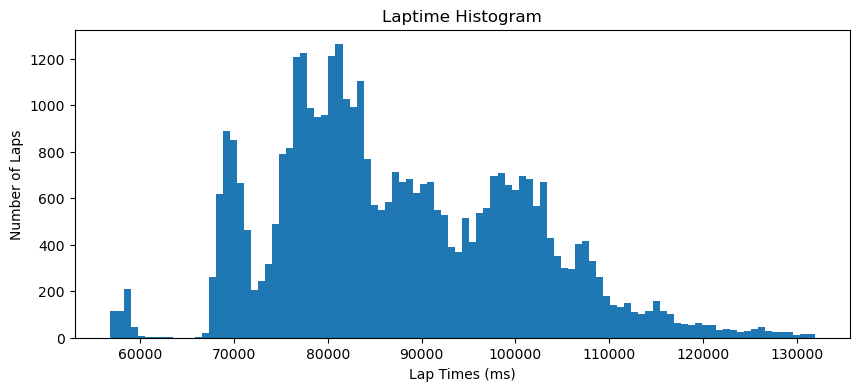

In [18]:
plt.figure(figsize=(10,4))
plt.hist(df['milliseconds'].values, bins=100)
plt.xlabel('Lap Times (ms)')
plt.ylabel('Number of Laps')
plt.title('Laptime Histogram')
plt.savefig('Laptime Histogram.png') 
plt.show()

There are various peaks in this data, which is expected due to different track lengths and variations in car performance over the years. The data tapers off on the right side because pit stop laps and race starts necessarily have slower lap times. However, there is an obvious outlier below 60,000 ms, which comes from the 2020 Sakhir Grand Prix. This race will be removed to provide the model with more consistent data.

In [20]:
# Remove the 2020 Sakhir Grand Prix
strategies = strategies[strategies['raceId'] != 1046]
update_df()

Before I alter the pit stops dataframe, I will join it to the original lap times and save this information for later. It will be used for calculating additional metrics later.

In [22]:
# Inner join lap_times to races
lap_times = lap_times.set_index('raceId').join(races.set_index('raceId'), how='inner')
lap_times = lap_times.reset_index()
# Left join pit_stops to lap_times
pit_stops = pit_stops.set_index(['raceId','driverId','lap'])
lap_times = lap_times.set_index(['raceId','driverId','lap'])
lap_times = lap_times.join(pit_stops, on=['raceId','driverId','lap'], rsuffix='_pitstop', how='left')
lap_times = lap_times.reset_index()

Similarly to how I update the main dataframe, I will update the pit stops dataframe to remove unneeded pit stops, then I will remove strategies that contain bad pit stops.

In [24]:
# Remove pit stops not in strategies
pit_stops = pit_stops.join(filter_frame, how='inner')
pit_stops = pit_stops.reset_index() 

Let's look at a scatter plot of pit stops to determine the outliers.

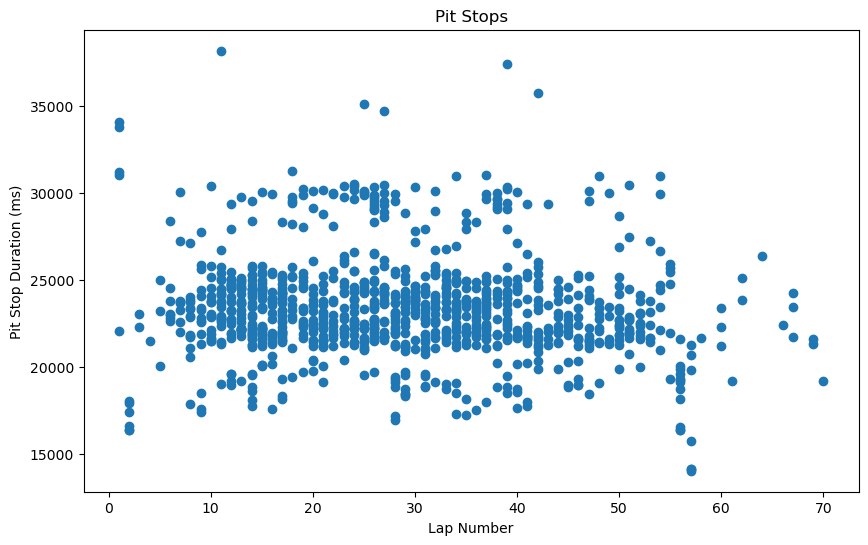

In [26]:
plt.figure(figsize=(10,6))
plt.scatter(pit_stops['lap'], pit_stops['milliseconds'])
plt.xlabel('Lap Number')
plt.ylabel('Pit Stop Duration (ms)')
plt.title('Pit Stops')
plt.savefig('Pitstop Lap vs Duration.png') 
plt.show()

It can be seen that pit stops have a consistent length of around 23 seconds, with variations resulting from the different pit lane lengths of different tracks. Outliers above 32 seconds will be removed, as they indicate some kind of problem during the pit stop. Additionally, pit stops that occur at lap 5 or earlier will be removed because they are indicative of a problem with the car or some other atypical situation. Similarly, pit stops after lap 65 will also be removed for the same reason.

In [28]:
# Mark strategies with bad pit stops
max_pitstop = 32000
pit_early = 5
pit_late = 65
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(pit_stops['milliseconds'], pit_stops['lap'], pit_stops['raceId'], pit_stops['driverId']):
    if row[0] > 0:
        if (row[0] > max_pitstop) or (row[1] <= pit_early) or (row[1] >= pit_late):
            strategies.at[(row[2], row[3]), 'bad'] = 1

update_df()

Here, I join the pit stop data to the main dataframe and create the target column for my model, pitNext. Since a pit stop always occurs at the end of a lap and consequently affects the lap time and data taken from that lap, the model needs to make a pit stop decision based on the previous lap's data. To correctly train the model, I need to add a column that indicates a pit stop on the *next* lap with a 1, or no pit stop on the next lap with a 0.

In [30]:
# Left join pit_stops to df
pit_stops = pit_stops.set_index(['raceId','driverId','lap'])
df = df.join(pit_stops, on=['raceId','driverId','lap'], rsuffix='Pitstop', how='left')

# Create boolean for pit stop next lap
pit_stops = pit_stops.reset_index()
pit_next_lap = pit_stops.loc[:, ['lap']] - 1 # Subtract 1 to add the bool on the lap before a pit stop 
pit_next_lap['raceId'] = pit_stops['raceId']
pit_next_lap['driverId'] = pit_stops['driverId']
pit_next_lap['pitNext'] = 1

# Left join pit_next_lap to df
pit_next_lap = pit_next_lap.set_index(['raceId','driverId','lap'])
df = df.join(pit_next_lap, on=['raceId','driverId','lap'], how='left')
df['pitNext'] = df['pitNext'].fillna(0)

### Data processing

In this section I add additional columns with information processed from the data that will provide valuable additional insight to the model.
I will add columns for:
- Laps since last pit stop
- Race progress value between 0 and 1
- Time split from the previous lap
- Time gap to the car ahead
- Is DRS available
- Time gap to the car behind
- Did the car ahead pit stop
- Did the car behind pit stop

I will use list comprehension to generate lists that will be added to the main dataframe as columns. This is a very fast and efficient way to iterate through the dataframe and add new columns based on the data.

First, I will create a column that tracks the number of laps since the last pit stop occurred. This count will be 0 at the start of the race and 0 for any pit stop laps, then it will increment for each subsequent lap.

In [33]:
# Calculate laps since last pit stop
count = 0
def last_pit(lap, pitstop):
    global count
    
    if (lap == 1) or (not np.isnan(pitstop)):
        count = 0
        return count
    
    count += 1
    return count
    
df['lapsSincePit'] = [
    last_pit(row[0], row[1])
    for row in zip(df['lap'], df['stop'])
]

Next, I will calculate the race progress, which will simply be the current lap divided by the total laps in the race. Since each race may have a different total number of laps, I will iterate through the dataframe backwards to determine the length of each race by identifying the last lap first.

In [35]:
# Create race progress column
# Reverse df for easy iteration backwards
reverse_df = df.iloc[::-1].reset_index().iloc[:,1::]

race_length = 0
def progress(lap):
    global race_length
    
    if lap > race_length:
        race_length = lap
        
    prog = lap / race_length
    
    if lap == 1:
        race_length = 0
    
    return prog

reverse_df['raceProgress'] = [
    progress(row[0])
    for row in zip(reverse_df['lap'])
]

# Unreverse df
df = reverse_df.iloc[::-1].reset_index().iloc[:,1::]

Next, I will calculate the split between laps. For lap 1, this value will be set to zero. For all other laps, it will be the difference between the current lap time and the previous lap time.

In [37]:
# Time split from previous lap 
prev = 0
def split_calculate(lap, laptime):
    global prev
    
    if lap == 1:
        prev = laptime
        return 0
        
    split = laptime - prev
    prev = laptime
    
    return split
    
df['split'] = [
    split_calculate(row[0], row[1])
    for row in zip(df['lap'], df['milliseconds'])
]

Next, I will maintain a cumulative total of each driver’s race time by summing their lap times. This will enable me to calculate the gap between any two drivers at the end of each lap, which is a crucial metric in Formula 1. Having this information will indicate how closely two cars are racing on the track at the end of each lap.

In [39]:
# Create column with total time since race start in df
prev = 0;
def total_calc(lap, laptime):
    global prev
    
    if lap == 1:
        prev = laptime
        return laptime
    
    prev += laptime
    
    return prev

df['totalTime'] = [
    total_calc(row[0], row[1])
    for row in zip(df['lap'], df['milliseconds'])
]

I also need to perform the same calculation for every driver, including those I have eliminated from my dataset. This information will be necessary to calculate the time gaps between any two cars.

In [41]:
# Create column with total time since race start in lap_times 
# This is needed to calculate time gaps for any car
lap_times['totalTime'] = [
    total_calc(row[0], row[1])
    for row in zip(lap_times['lap'], lap_times['milliseconds'])
]

Next, I calculate the time gaps to the car currently ahead of each driver in my dataset. This involves searching the dataframe containing all lap times for the driver in the same race, on the same lap, but one position ahead (one lower in value), and then taking the difference between their total times.

Drivers in first place will be given a gap of 40 seconds so that the model will learn that they do not have any cars in front of them to worry about.

In [43]:
# Create a column with the time gap to the car ahead
max_gap = 40000 # This is used in place of 
def gap_ahead(position, raceId, lap, totalTime):
    if position > 1:
        car_ahead = position - 1
        
        car_ahead_time = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_ahead), 
            'totalTime'
        ].iloc[0]
        
        gap = totalTime - car_ahead_time
        return gap
    return max_gap

print('Calculating gapAhead...')
df['gapAhead'] = [
    gap_ahead(row[0], row[1], row[2], row[3])
    for row in zip(df['position'], df['raceId'], df['lap'], df['totalTime'])
]
print('Done')

Calculating gapAhead...
Done


There is some bad data in here so I will have to perform more filtering. I will remove strategies with a gap ahead greater than 40 seconds (indicating poor or unusual performance) or negative gaps which should not be possible. 

In [45]:
# Mark strategies with a large or negative gap, indicating bad data
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(df['gapAhead'], df['raceId'], df['driverId']):
    if not np.isnan(row[0]):
        if row[0] > max_gap or row[0] < 0:
            strategies.at[(row[1], row[2]), 'bad'] = 1
         
update_df()

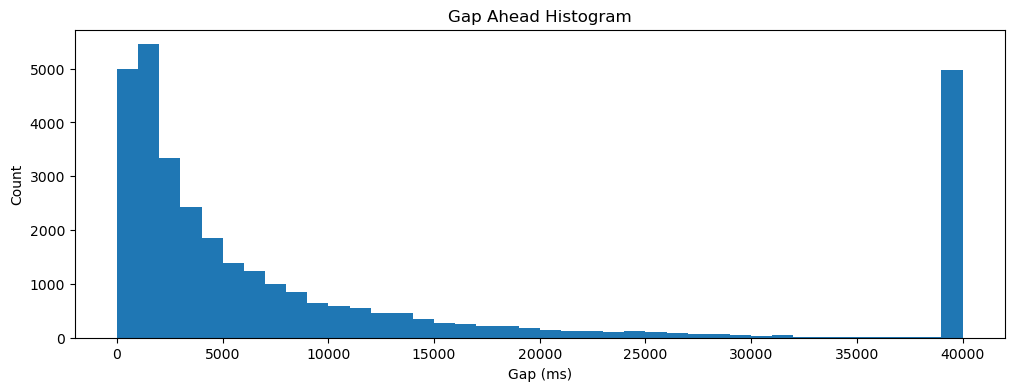

In [46]:
plt.figure(figsize=(12,4))
plt.hist(df['gapAhead'].values, bins=40)
plt.xlabel('Gap (ms)')
plt.ylabel('Count')
plt.title('Gap Ahead Histogram')
plt.show()

Looking at this historgram, we see that most drivers are able to stay within a gap of 5 seconds to the car ahead for the majority of laps. A peak at 40 seconds was artificially created for any cars in first place which do not have a gap ahead.

Under the current rules, a driver can only use the Drag Reduction System (DRS) if they are within one second of the car ahead when passing specific points on the track. Whether or not a driver has access to DRS is an important factor to consider when deciding whether to make a pit stop.

In [49]:
# DRS available boolean?

df['DRS'] = [
    (1 if row[0] < 1000 else 0)
    for row in zip(df['gapAhead'])    
]

Exactly like with the gap ahead, next I calculate the gap to the car behind.

In [51]:
# Calculate gap to the car behind 
max_bgap = 90000
def gap_behind(position, raceId, lap, totalTime):
    try:
        car_behind = position + 1
        
        car_behind_time = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_behind), 
            'totalTime'
        ].iloc[0]
        
        gap = car_behind_time - totalTime
        return gap
    except:    
        return max_bgap

print('Calculating gapBehind...')
df['gapBehind'] = [
    gap_behind(row[0], row[1], row[2], row[3])
    for row in zip(df['position'], df['raceId'], df['lap'], df['totalTime'])
]
print('Done')

Calculating gapBehind...
Done


In [52]:
# Mark strategies with a negative gap, indicating bad data
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(df['gapBehind'], df['raceId'], df['driverId']):
    if not np.isnan(row[0]):
        if row[0] > max_bgap or row[0] < 0:
            strategies.at[(row[1], row[2]), 'bad'] = 1
            
update_df()

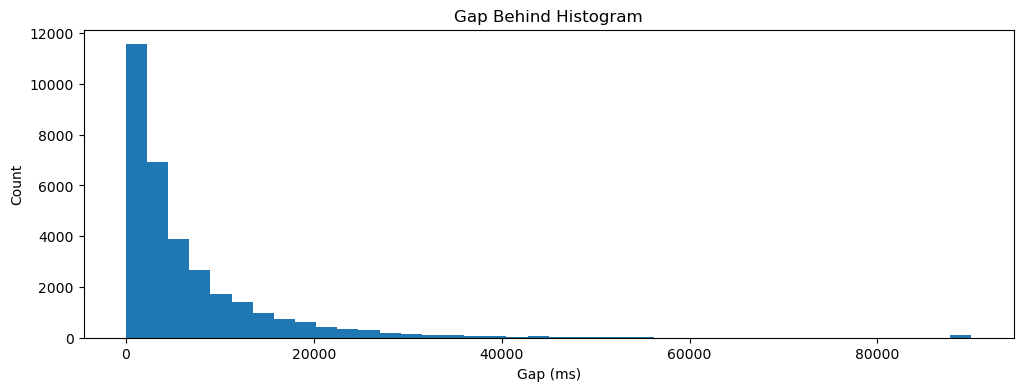

In [53]:
plt.figure(figsize=(12,4))
plt.hist(df['gapBehind'].values, bins=40)
plt.xlabel('Gap (ms)')
plt.ylabel('Count')
plt.title('Gap Behind Histogram')
plt.show()

This histogram displays results similar to those of the gap ahead histogram. Most cars are able to remain close to each other for the majority of the laps. In this case, I allow for larger gaps because a significant gap behind typically indicates a successful performance from a driver.

Finally, I will create two additional columns that provide valuable information to the model. These columns will contain boolean values indicating whether the car ahead makes a pit stop (column 1) or whether the car behind makes a pit stop (column 2). This information is crucial due to common pit stop strategies, such as overcutting and undercutting.

- Undercutting is the strategy of making a pit stop earlier than the car ahead, with the aim of achieving quicker lap times on fresh tires. The goal is for the driver who executed the undercut to pass the car ahead while it is in the pits.
- Overcutting, on the other hand, involves making a pit stop later than the car ahead, allowing the driver to capitalize on the performance of worn tires for as long as possible. The intention is to exit the pits with fresher tires, making it easier to overtake the car ahead.

I want to provide the neural network with the information necessary to execute these strategies effectively or defend against them.

In [56]:
# Did the car ahead pit boolean?
def pit_ahead(position, raceId, lap):
    if position > 1:
        car_ahead = position - 1
        
        car_ahead_stop = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_ahead), 
            'stop'
        ].iloc[0]
        
        if not np.isnan(car_ahead_stop):
            return 1
        return 0
    
    return 0

print('Calculating pitAhead...')
df['pitAhead'] = [
    pit_ahead(row[0], row[1], row[2])
    for row in zip(df['position'], df['raceId'], df['lap'])
]
print('Done')

Calculating pitAhead...
Done


In [57]:
# Did the car behind pit bool?
def pit_behind(position, raceId, lap):
    try:
        car_behind = position + 1
        
        car_behind_stop = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_behind), 
            'stop'
        ].iloc[0]
        
        if not np.isnan(car_behind_stop):
            return 1
        return 0
    except:
        return 0

print('Calculating pitBehind...')
df['pitBehind'] = [
    pit_behind(row[0], row[1], row[2])
    for row in zip(df['position'], df['raceId'], df['lap'])
]
print('Done')

Calculating pitBehind...
Done


### Pit Stop Laps Analysis

Here I want to take a look at the laps that occur before pit stops. These are the laps that the model will have to identify.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pit_stop_decision_laps = df[df['pitNext'] == 1]

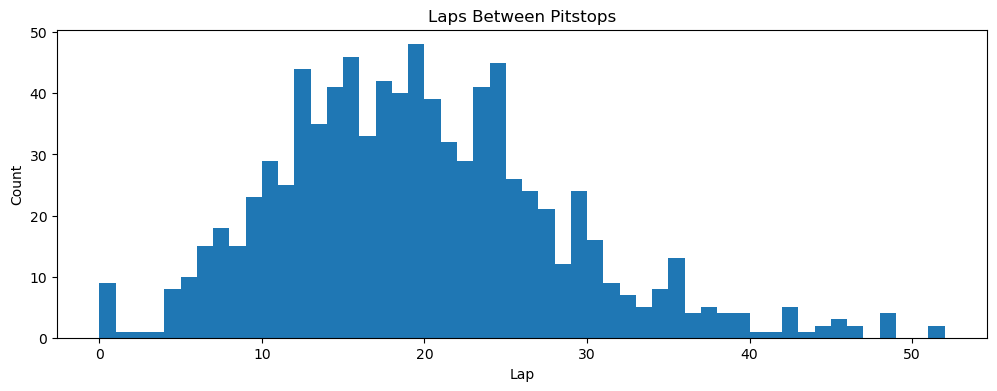

In [60]:
plt.figure(figsize=(12,4))
lapBins = pit_stop_decision_laps['lapsSincePit'].values.max()
plt.hist(pit_stop_decision_laps['lapsSincePit'].values, bins=range(lapBins))
plt.xlabel('Lap')
plt.ylabel('Count')
plt.title('Laps Between Pitstops')
plt.savefig('Laps Between Pitstops.png') 
plt.show()

This histogram displays the number of laps a driver completes before making a pit stop. While this depends on many factors, we can still observe a fairly normal distribution that is only slightly skewed to the right.

However, there is a problematic peak at 0 laps which indicates the presence of some erroneous data. I will remove these strategies from the dataframe to ensure data quality.

In [62]:
bad_laps = pit_stop_decision_laps[pit_stop_decision_laps['lapsSincePit'] < 5]

strategies = strategies.set_index(['raceId', 'driverId'])
for row in zip(bad_laps['raceId'], bad_laps['driverId']):
    strategies.at[(row[0], row[1]), 'bad'] = 1
            
update_df()
pit_stop_decision_laps = df[df['pitNext'] == 1]

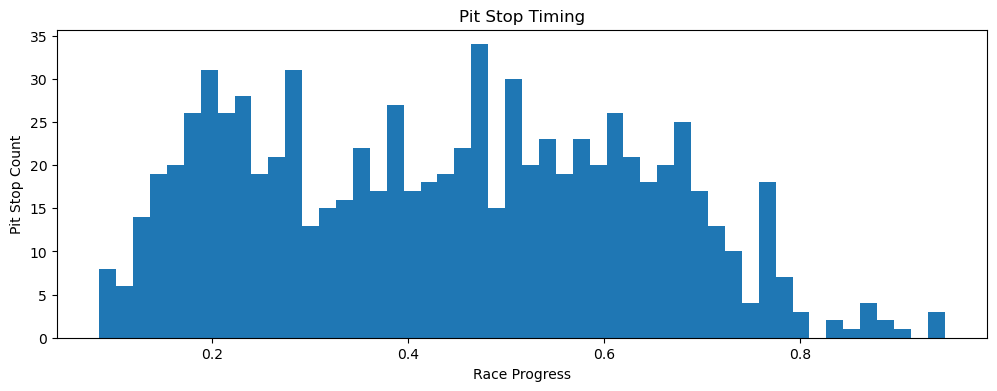

In [63]:
plt.figure(figsize=(12,4))
plt.hist(pit_stop_decision_laps['raceProgress'].values, bins=50)
plt.xlabel('Race Progress')
plt.ylabel('Pit Stop Count')
plt.title('Pit Stop Timing')
plt.savefig('Pit Stop Timing.png') 
plt.show()

This histogram illustrates the points in time during a race when pit stops are made. We observe a pronounced peak around 0.2, but the rest of the data is fairly evenly distributed. This suggests that there isn’t a single dominant pit stop strategy that drivers consistently follow across all races. In other words, selecting a universal strategy for all races is not feasible.

Now that I am done with the data, I will save a copy of the dataframe.

In [66]:
df.to_csv('processed_data.csv', index=False)

## LSTM Hybrid Network
In this section, I will create and train a neural network using the processed data. The architecture I have chosen is a hybrid model that combines a Long Short-Term Memory (LSTM) recurrent neural network with a traditional Feed Forward Neural Network (FFNN). This approach leverages the strengths of the LSTM in modeling time series data and maintaining memory over extended periods, while also utilizing the FFNN's ability to replicate complex patterns without the potential complications associated with recurrent networks.

### Preparing the data for training
First I will load the processed data and seperate it into training and testing sets. Three recent 2024 races are chosen as the test data to evaulate the model's performance on modern races.

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from matplotlib.ticker import MaxNLocator

In [70]:
df = pd.read_csv('processed_data.csv')

# Seperate data from 3/102 races for testing
df_test = df[df['raceId'].isin([1131, 1130, 1123])]
df_train = df[~df['raceId'].isin([1131, 1130, 1123])]

# Take the necessary columns and separate the inputs/output.
X_test = df_test.iloc[:, 2:5].join(df.iloc[:, 9:12]).join(df.iloc[:, 13::])
y_test = df_test.iloc[:, 8]
X_train = df_train.iloc[:, 2:5].join(df.iloc[:, 9:12]).join(df.iloc[:, 13::])
y_train = df_train.iloc[:, 8]

# Examine the test set 
X_test

,lap,position,milliseconds,lapsSincePit,raceProgress,split,gapAhead,DRS,gapBehind,pitAhead,pitBehind
29019,1,11,94503,0,0.017241,0,815,1,260,0,0
29020,2,11,84284,1,0.034483,-10219,1044,0,320,0,0
29021,3,11,82978,2,0.051724,-1306,952,1,614,0,0
29022,4,10,83742,3,0.068966,764,1258,0,577,0,0
29023,5,10,83294,4,0.086207,-448,996,1,843,0,0
...,...,...,...,...,...,...,...,...,...,...,...
31345,67,2,69532,16,0.943662,-17500,3061,0,1253,0,0
31346,68,2,69241,17,0.957746,-291,2657,0,2393,0,0
31347,69,2,69159,18,0.971831,-82,2069,0,2976,0,0
31348,70,2,69989,19,0.985915,830,2431,0,2688,0,0


Above, you can see the columns of data that I will provide to the network. In total, there are 11 columns that become the inputs I will use to train the network.

I will convert the sets to tensors for use with PyTorch and I will save a copy that will be used by my algorithms to decode and sort the data later.

In [73]:
# Convert the sets to tensors for use with pytorch
X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float().unsqueeze(1)
y_test = torch.tensor(y_test.values).float().unsqueeze(1)

# Save a copy to be used by algorithms that segment and batch the data
X_test_original = X_test 
X_train_original = X_train

When training and using a neural network, it’s important to scale all input data so that the values are similar, typically between -1 and 1. For my data, I have chosen to use a min-max scaling approach, as it works well for most of the columns. Data such as lap, position, lapsSincePit, raceProgress, and the boolean values for DRS, pitAhead, and pitBehind will scale effectively with this method. The result will be the same data, but normalized to fit between 0 and 1.

In [75]:
# Minmax the data
min_val = X_train.min(axis=0)[0]  # Column-wise min
max_val = X_train.max(axis=0)[0]  # Column-wise max
X_train = (X_train - min_val) / (max_val - min_val)  # Scale training data to [0, 1]
X_test = (X_test - min_val) / (max_val - min_val)    # Scale test data using training min and max


### Segmenting and Batching
Since I will be using LSTM layers in my network, I need to create overlapping windows of data to feed into the model. After testing various sizes, I have chosen a window size of 3 laps.

Rather than creating placeholder data for laps -1 and -2 at the start of the race to enable the model to make predictions for lap 1, I have chosen to begin the model’s predictions at lap 3. I can safely assume that under normal circumstances, no pit stops will be made this early in a race.

In [77]:
def LSTM_data_segments(X_orig, X, y, WS):
    X_segments = []
    y_values = []
    i = 0
    while (i < len(X)):
        if X_orig[i][0] == 1: # If lap = 1, jump to lap window size
            i += WS - 1
            continue
        X_segments.append(X[i-WS+1:i+1]) # Append the window
        y_values.append(y[i]) # Append the pit stop decision
        i += 1

    # convert to tensors
    X_segments = torch.stack(X_segments)  # Stack X_segments list into a single tensor
    y_values = torch.stack(y_values)
    return X_segments, y_values

WS = 3 # Window size (number of laps to evaluate at a time)

X_test, y_test = LSTM_data_segments(X_test_original, X_test, y_test, WS)
X_train, y_train = LSTM_data_segments(X_train_original, X_train, y_train, WS)

print(X_test[0][0])

tensor([0.0000, 0.5000, 0.4308, 0.0000, 0.0045, 0.5221, 0.0204, 1.0000, 0.0029,
        0.0000, 0.0000])


Now that the data is formatted into windows for the LSTM, I will create batches of data to provide to the model during training. The LSTM layer will maintain its cell and hidden states as it takes in multiple windows, resetting them after each new batch. This has led me to the decision to create batches based on individual strategies, allowing the model to learn how to predict a single strategy more effectively without carrying over any memory from one strategy to another.

In [79]:
# Custom batches based on complete strategies
def LSTM_data_batches(X, y):
    X_batches = []
    y_batches = []

    j = 0
    for i in range(len(X)):

        if X[i][2][4] > 0.999: # Race progress == 1 (end of race)
            X_batches.append(X[j:i+1])
            y_batches.append(y[j:i+1])
            j = i + 1

    return X_batches, y_batches
    
X_test_batches, y_test_batches = LSTM_data_batches(X_test, y_test)
X_train_batches, y_train_batches = LSTM_data_batches(X_train, y_train)

### Defining the Neural Network
For the network, I chose to use a single LSTM layer followed by two fully connected layers, creating a hybrid between a recurrent neural network and a feed-forward neural network. This architecture is well-suited for the task because it combines the memory retention of an LSTM with the simplicity of an FFNN. I opted for only three layers in total to reduce the risk of overfitting the model.

In [81]:
class LSTMHybrid(nn.Module):
    def __init__(self, input_size=11, hidden_size=128, num_layers=1, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers    

        #LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), # Layer 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), # Layer 2
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)  # Final output layer
        )

    def forward(self, x):
        # Create zeroed hidden and cell states
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Pass the input as well as the zero hidden and cell states through the LSTM
        out, _ = self.lstm(x, (hidden_states, cell_states))
        out = out[:, -1, :]  # Get the output of the last time step
        
        # Pass the last time stop through fully connected layers
        out = self.fc_layers(out)
        
        return out

This is a binary classification problem (predicting whether to make a pit stop or not), which calls for a binary loss function during training. It's crucial to apply a weight to the positive case (making a pit stop) because pit stops account for only about 3% of all laps. Without this weighting, the model might always predict "no pit stop," achieving 97% accuracy but ultimately being useless for making accurate pit stop predictions.

In [83]:
model = LSTMHybrid(11, 128, 1, 1)

pit_weight = ((len(y_train) - y_train.sum()) / y_train.sum()) # Calculated weight
print(pit_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight = pit_weight) # Binary cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.0003)

tensor(36.7182)


### Training the Network
The loss vs. epoch graph suggests that the model could benefit from further training to reduce the loss on the training data. However, I found that extending the training leads to overfitting, resulting in worse performance on the test data. As a result, I opted for early stopping after only a small number of epochs.

I also tested shuffling the batches for every epoch of training, but this surprisingly resulted in worse performance on the test data. I hypothesize that this is due to the nature of my training data, which dates back to 2014. By training the batches in chronological order—from oldest to newest—each epoch allows the more recent data to have a greater influence on the final result. This seems to be a desirable outcome, as more recent strategies are likely to be more relevant in today’s Formula 1 racing.

In [85]:
num_epochs = 25
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0

    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(X_train_batches)
    losses.append(epoch_loss)
    if (epoch + 1) % 3 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {epoch_loss}')

Epoch [3], Loss: 1.0481566709734627
Epoch [6], Loss: 0.9558757777815148
Epoch [9], Loss: 0.9155696022434759
Epoch [12], Loss: 0.8896887059623407
Epoch [15], Loss: 0.8674823728910948
Epoch [18], Loss: 0.8491089312770104
Epoch [21], Loss: 0.8343991172200037
Epoch [24], Loss: 0.8231241599483005


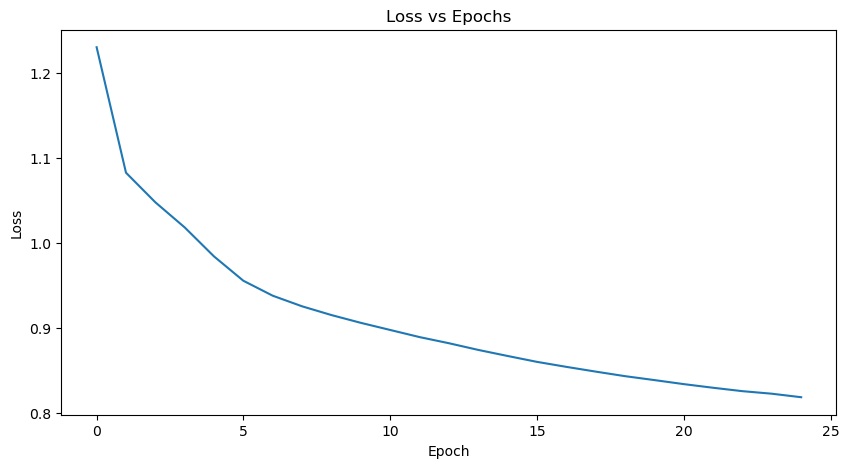

In [86]:
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.savefig('Loss vs Epochs.png') 
plt.show()

### Evaluating the Model
At this stage, I will pass the testing set through the model and evaluate the loss function to assess how well the model fits data it has not been trained on.

In [165]:
model.eval()
total_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():  # Disable gradient computation. It is only needed for training
    
    for X_batch, y_batch in zip(X_test_batches, y_test_batches):
        # Forward pass
        y_pred = model(X_batch)
        # Calculate loss
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()  # Accumulate total loss

        predictions.append(y_pred)
        true_labels.append(y_batch)

average_loss = total_loss / len(X_test_batches)

predictions = torch.cat(predictions)  # Combine all predictions into a single tensor
true_labels = torch.cat(true_labels)  # Combine all true labels into a single tensor

# Print average loss
print(f'Average Loss on Test Set: {average_loss}')

Average Loss on Test Set: 1.1327799022197724


To evaluate and visualize the model's performance on the test data, I need to reconstruct the strategies by reinserting all laps 1 and 2 into the results. These laps will be set to 0 (no pit stop) and then appended to the original test dataframe.

In [168]:
# Reasemble the predictions from the segments (insert the missing lap 1s and 2s as "no pit stop")
result = []
j = 0
for i in range(len(X_test_original)):
    if X_test_original[i][0] >= WS:
        result.append(torch.sigmoid(predictions[j]))
        j += 1
    else:
        result.append(0)

print(len(X_test_original), len(result)) # Verify no missing data

1623 1623


In [170]:
test = df_test.copy()
test['predictedNext'] = result

To objectively evaluate the model's performance, I will calculate the precision, recall, and F1 scores (not to be confused with Formula 1) for the predicted data. Any model output greater than 0.5 will be considered a true, while anything below 0.5 will be treated as a false.

Among these metrics, the recall score will be the most important because I want to prioritize the model's ability to catch every potential pit stop. It's acceptable if the model predicts pit stops slightly early, as this still signals to race engineers that the pit stop window is approaching.

In [173]:
f1 = f1_score((test['pitNext'] > 0), (test['predictedNext'] >= 0.5))
recall = recall_score((test['pitNext'] > 0), (test['predictedNext'] >= 0.5))
precision = precision_score((test['pitNext'] > 0), (test['predictedNext'] >= 0.5))

print(f'F1 Score: {f1:.3f}',)
print(f'Recall Score: {recall:.3f}',)
print(f'Precision Score: {precision:.3f}',)

F1 Score: 0.290
Recall Score: 0.706
Precision Score: 0.183


### Visualizing the Results
While the metrics provide an important measure of performance, it's crucial to visualize the model’s output to ensure it is behaving as intended and delivering useful predictions. I will plot two races and observe how the model predicts pit stops for two drivers, each employing different strategies.

In [176]:
race1 = test[test['raceId'] == 1130]
print(race1['driverId'].unique())
driver1_1 = race1[race1['driverId'] == 1] # Hamilton
driver2_1 = race1[race1['driverId'] == 815] # Perez

[  1 815 830 832 844 847 857]


In [178]:
race2 = test[test['raceId'] == 1131]
print(race2['driverId'].unique())
driver1_2 = race2[race2['driverId'] == 832] # Sainz
driver2_2 = race2[race2['driverId'] == 817] # Ricciardo

[  1 807 815 817 825 832 842 847 857]


The plots will display the model's output for each lap of the race, visualized by the height of a diamond on the y-axis. A vertical line will mark each lap where the drivers actually decided to pit on the following lap. Additionally, a horizontal dotted line at y = 0.5 will indicate the threshold, where values above suggest favoring a pit stop and values below favor staying out on the track. I will also plot the driver positions on a separate graph to provide insight into the model's predictions and to analyze how effective each strategy was for the drivers.

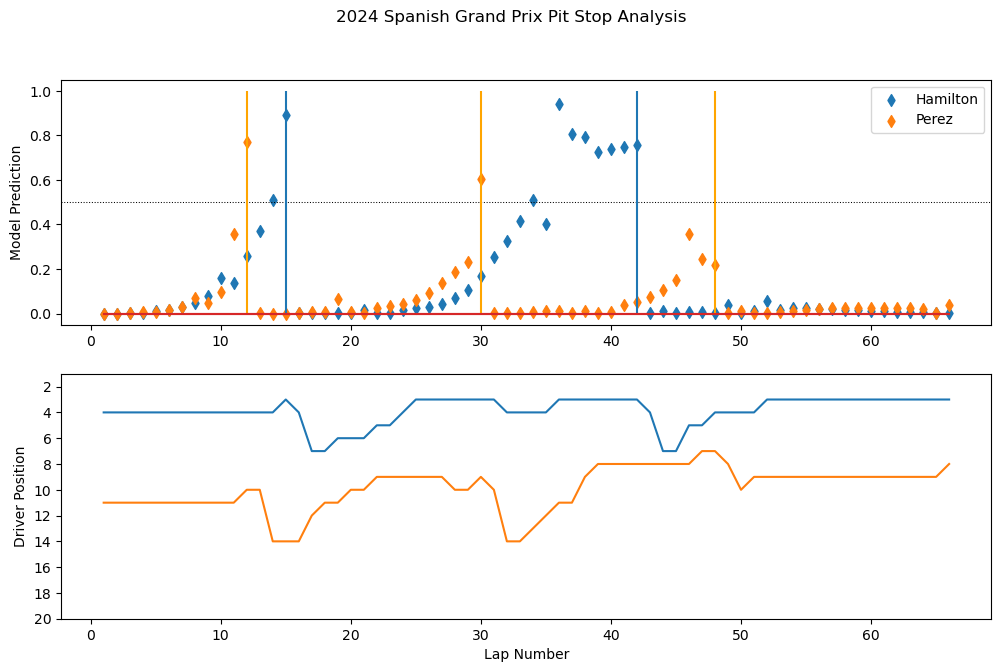

In [181]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 7))
fig.suptitle('2024 Spanish Grand Prix Pit Stop Analysis')

ax1.axhline(y=0.5, color='black', linestyle=':', linewidth=0.75)
ax1.scatter(driver1_1['lap'], driver1_1['predictedNext'], marker='d', label='Hamilton')
ax1.stem(driver1_1['lap'], driver1_1['pitNext'], markerfmt='none')
ax1.scatter(driver2_1['lap'], driver2_1['predictedNext'], marker='d', label='Perez')
ax1.stem(driver2_1['lap'], driver2_1['pitNext'], markerfmt='none', linefmt='orange')
ax1.set_ylabel('Model Prediction')

ax2.plot(driver1_1['lap'], driver1_1['position'])
ax2.plot(driver2_1['lap'], driver2_1['position'])
ax2.set_ylim(1, 20)
ax2.set_ylabel('Driver Position') 
ax2.set_xlabel('Lap Number')
ax2.invert_yaxis()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.legend()

plt.savefig('2024 Spanish Grand Prix Pit Stop Analysis.png') 

In the plot above, we can see how the model responds to both a two-stop and a three-stop strategy during the same race. The model successfully adjusts to each strategy, accurately predicting 4 out of 5 stops. It only misses Perez's third pit stop, but it correctly trends upward around the time of the stop, indicating that the model was close to making the correct prediction or that Perez could have stayed out on track for longer.

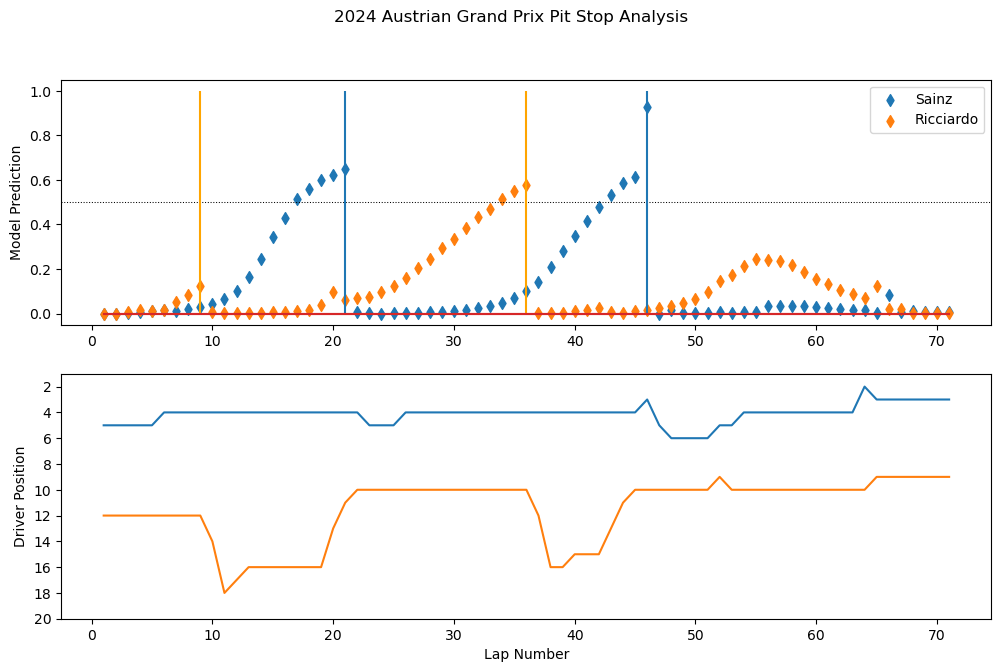

In [184]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 7))
fig.suptitle('2024 Austrian Grand Prix Pit Stop Analysis')

ax1.axhline(y=0.5, color='black', linestyle=':', linewidth=0.75)
ax1.scatter(driver1_2['lap'], driver1_2['predictedNext'], marker='d', label='Sainz')
ax1.stem(driver1_2['lap'], driver1_2['pitNext'], markerfmt='none')
ax1.scatter(driver2_2['lap'], driver2_2['predictedNext'], marker='d', label='Ricciardo')
ax1.stem(driver2_2['lap'], driver2_2['pitNext'], markerfmt='none', linefmt='orange')
ax1.set_ylabel('Model Prediction')

ax2.plot(driver1_2['lap'], driver1_2['position'])
ax2.plot(driver2_2['lap'], driver2_2['position'])
ax2.set_ylim(1, 20)
ax2.set_ylabel('Driver Position') 
ax2.set_xlabel('Lap Number')
ax2.invert_yaxis()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.legend()

plt.savefig('2024 Austrian Grand Prix Pit Stop Analysis.png') 

In this plot, we again observe how the model responds to two different strategies. It accurately predicts 3 out of the 4 stops, only missing Ricciardo’s first stop, which occurred very early in the race as part of an alternate strategy by his team. However, the model adjusts to this strategy and correctly predicts his final stop.

### Saving the model
The model is performing well, so I will save its state for future use.

In [103]:
perform_save = False # Manually change to True to save the current state of the model

if perform_save:
    save_state = {
        'model':model.state_dict(), 
        'optimizer':optimizer.state_dict(), 
        'min_val': min_val, # Used for min max on input data
        'max_val': max_val
        }
    torch.save(save_state, 'LSTM_hybrid_trained_V3.pth')

## User Interface
This section will enable you to input data lap by lap and observe the model's output for any given data.

In [105]:
import torch
import ipywidgets as widgets
from IPython.display import display
from lstmhybrid import LSTMHybrid

state = torch.load('LSTM_hybrid_trained_V3.pth')

model = LSTMHybrid()
model.load_state_dict(state['model'])
model.eval()
min_val = state['min_val'] # Used for min max on input data
max_val = state['max_val']

The user interface below allows you to directly use the model. It will automatically increment laps as you enter them and reset fields that require new input for each lap. After entering 3 laps of data, the model will begin to display its output, indicating how confident it is that your car should make a pit stop on the next lap. Here is a description of the input fields:

| **Metric**         | **Description**                                                       |
|--------------------|-----------------------------------------------------------------------|
| Race Length        | The total number of laps in a given race                              |
| Lap                | The lap currently being evaluated                                     |
| Lap Last Pit       | The lap that a pit stop was last performed                            |
| Position           | The current place of the driver in the field (1st, 2nd, 3rd...)       |
| Laptime (ms)       | The time taken to complete this lap, given in milliseconds            |
| Gap Ahead          | The time gap to the car a position ahead, given in milliseconds       |
| Gap Behind         | The time gap to the car a position behind, given in milliseconds      |
| Car Ahead Pit      | Did the car ahead make a pit stop?                                    |
| Car Behind Pit     | Did the car behind make a pit stop?                                   |

In [107]:
#### Create input fields
race_length = widgets.IntText(description='Race Length:')
lap = widgets.IntText(description='Lap:')
last_pit = widgets.IntText(description='Lap Last Pit:')
position = widgets.IntText(description='Position:')
laptime = widgets.IntText(description='Laptime (ms):')
gap_ahead = widgets.IntText(description='Gap Ahead:')
pit_ahead = widgets.Checkbox(value=False, description='Car Ahead Pit')
gap_behind = widgets.IntText(description='Gap Behind:')
pit_behind = widgets.Checkbox(value=False, description='Car Behind Pit')

submit_button = widgets.Button(description='Input Lap')
reset_button = widgets.Button(description='Reset Data')
hbox = widgets.HBox([submit_button, reset_button])

output = widgets.Output(layout={'border': '1px solid black', 'padding': '5px', 'width': '300px', 'height': '70px'})

# Variables for the function
last_lap = 0
window = torch.zeros(1, 3, 11)
batch = []
count = 0

# Define a function to handle the button click
def on_submit(b):
    with output:
        output.clear_output()
        global last_lap, count, window, batch

        # Input validation 
        if race_length.value <= 0:
            print('Error: Race Length must be greater than 0')
            return
        if lap.value <= 0 or lap.value > race_length.value:
            print('Error: Lap must be greater than 0 and less than or equal to Race Length')
            return
        if laptime.value <= 0:
            print('Error: Laptime must be greater than 0')
            return
        if gap_ahead.value < 0 or gap_behind.value < 0:
            print('Error: Gap Ahead and Gap Behind must be non-negative')
            return
        if last_pit.value < 0 or last_pit.value > lap.value:
            print('Error: Lap Last Pit must be non-negative and less than or equal the current Lap')
            return
        
        # create tensor from input
        lap_data = torch.tensor([
            lap.value,
            position.value,
            laptime.value, # milliseconds
            (lap.value - last_pit.value), # lapsSincePit
            (lap.value / race_length.value), # raceProgress
            (0 if last_lap == 0 else (laptime.value - last_lap)), #split
            gap_ahead.value,
            (1 if gap_ahead.value < 1000 else 0), # DRS
            gap_behind.value,
            (1 if pit_ahead.value else 0),
            (1 if pit_behind.value else 0)
        ])
        
        last_lap = laptime.value # used to calculate splits automatically
        
        # Minmax data
        lap_data = (lap_data - min_val) / (max_val - min_val) 
        
        # Insert data to tensor
        window[0][0] = window[0][1]
        window[0][1] = window[0][2]
        window[0][2] = lap_data

        # evaluate with model and display
        count += 1        
        pit_pred = 0
        if count >= 3:
            batch.append(window)
            batch_tensor = torch.cat(batch, dim=0)
            pit_pred = torch.sigmoid(model(batch_tensor))
            print(f'Pit stop on lap {lap.value+1} confidence: {(pit_pred[-1].item() * 100):.1f}%')
        else:
            print('Input', (3 - count), 'more laps for evaluation')
        
        lap.value += 1
        laptime.value = 0
        gap_ahead.value = 0
        pit_ahead.value = False
        gap_behind.value = 0
        pit_behind.value = False

def on_reset(b):
    with output:
        output.clear_output()
        global last_lap, count, window, batch

        last_lap = 0
        window = torch.zeros(1, 3, 11)
        count = 0
        batch = []
        race_length.value = 0
        lap.value = 0
        last_pit.value = 0
        position.value = 0
        laptime.value = 0
        gap_ahead.value = 0
        pit_ahead.value = False
        gap_behind.value = 0
        pit_behind.value = False
        print('Input data has been reset')

# Link the button click event to the function
submit_button.on_click(on_submit)
reset_button.on_click(on_reset)

# Disply the form
form = widgets.VBox([race_length, lap, last_pit, position, laptime, gap_ahead, gap_behind, pit_ahead, pit_behind, hbox, output],
                    layout=widgets.Layout(border='solid 1px black', padding='10px'))
centered_form = widgets.HBox([form], layout=widgets.Layout(justify_content='center'))
display(centered_form)

You can use the following sample data to see how it works: **Set Race Length = 71**, **Lap Last Pit = 22**, and **Position = 4**, then start entering the data below beginning from Lap 41. Observe the model's outputs and try to decide when to make a pit stop based on the predictions. Once you've chosen a lap to pit, update **Lap Last Pit** to that lap and enter one more lap of data to see how the model adapts to your decision.

| Lap | Laptime | Gap Ahead | Gap Behind | Car Ahead Pit | Car Behind Pit |
|-----|---------|-----------|------------|---------------|----------------|
|  41 |   70729 |      3953 |       3059 |             0 |              0 |
|  42 |   70906 |      4062 |       3099 |             0 |              0 |
|  43 |   70813 |      4091 |       3088 |             0 |              0 |
|  44 |   71214 |      3920 |       3205 |             0 |              0 |
|  45 |   71081 |      3599 |       3001 |             0 |              0 |
|  46 |   71088 |     16147 |       1000 |             0 |              1 |
|  47 |   74811 |       182 |      12333 |             0 |              0 |
|  48 |   86343 |      4846 |       2724 |             0 |              0 |
|  49 |   69555 |      5113 |       4879 |             0 |              0 |
|  50 |   69357 |      5128 |       6976 |             0 |              0 |
|  51 |   69412 |      4781 |      13827 |             0 |              1 |
|  52 |   70099 |      4999 |       6066 |             0 |              0 |

<details> 
    <summary>Once you've tried the model with this data sample, click here to see the actual pit stop.</summary> 
    <p>This data comes from Carlos Sainz during the 2024 Austrian Grand Prix, as shown in the graphs from previous sections. He made his second pit stop on <b>lap 47</b>, where the model predicted with over 90% confidence that a pit stop was needed.</p> 
</details>